In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
from anndata import AnnData
import anndata
import matplotlib as mpl
import matplotlib.pyplot as plt
from tifffile import imread

In [ ]:
adata_exp0 = anndata.read_h5ad('C:/Users/mdichgan/Documents/Helmholtz/send_to_Jakob/spatial/counts_CPc_exp0_BA28.h5ad')

In [ ]:
adata_Yao = anndata.read_h5ad(
    'C:/Users/mdichgan/Documents/Helmholtz/send_to_Jakob/sc/Yao_150kcells_subsample_with_annotations_sparse_subset.h5ad')

In [ ]:
adata_Yao.obs["celltype"] = adata_Yao.obs["label"]

In [ ]:
def get_negative_marker_dict(adata_sp: AnnData, adata_sc: AnnData, key: str='celltype'):
    """add dictionary of negative marker genes for different celltypes
    
    Parameters
    ----------
    adata_sp : AnnData
        Annotated ``AnnData`` object with counts from spatial data
    key : str
        Celltype key in adata_sp.obs and adata_sc.obs

    Returns
    -------
    neg_marker_dict : dict[string: list]
        dictionary with celltypes as keys and corresponding negative marker genes as values
    """


    # Set threshold parameters
    min_number_cells=10 # minimum number of cells belonging to a cluster to consider it in the analysis
    max_ratio_cells=0.005 # maximum ratio of cells expressing a marker to call it a negative marker gene-ct pair

    #check that genes in spatial data is subset of genes in single cell data
    adata_sp = adata_sp[:,adata_sp.var_names.isin(adata_sc.var_names)]

    # Subset adata_sc to genes of spatial data
    adata_sc = adata_sc[:,adata_sp.var_names]           
    
    # # TMP fix for sparse matrices, ideally we don't convert, and instead have calculations for sparse/non-sparse
    # for a in [adata_sc, adata_sp]:
    #     if issparse(a.layers["raw"]):                                   #existiert dieser layer immer ->X?
    #         a.layers["raw"] = a.layers["raw"].toarray()
    
    # Get cell types that we find in both modalities
    shared_celltypes = adata_sc.obs.loc[adata_sc.obs[key].isin(adata_sp.obs[key]),key].unique()
    
    # Filter cell types by minimum number of cells
    celltype_count_sc = adata_sc.obs[key].value_counts().loc[shared_celltypes]
    celltype_count_sp = adata_sc.obs[key].value_counts().loc[shared_celltypes]   #vlt weg lassen? wieso wichtig?
    ct_filter = (celltype_count_sc >= min_number_cells) & (celltype_count_sp >= min_number_cells)
    celltypes = celltype_count_sc.loc[ct_filter].index.tolist()             #zelltypen in beiden größer als min_number_cells unique
    
    
    # Filter cells to eligible cell types
    adata_sc = adata_sc[adata_sc.obs[key].isin(celltypes)]
    genes = adata_sc.var_names
    
    # Get ratio of positive cells per cell type
    pos_exp_sc = pd.DataFrame(adata_sc.X.toarray() > 0,columns=adata_sp.var_names)     #wieso hier nur TRUE False, unten echter mean (neg_mark_pur)
    pos_exp_sc['celltype'] = list(adata_sc.obs[key])
    ratio_celltype_sc = pos_exp_sc.groupby('celltype').mean()
    
    # Get gene-cell type pairs with negative marker expression
    neg_marker_mask = np.array(ratio_celltype_sc < max_ratio_cells)
    

    neg_marker_mask = pd.DataFrame(neg_marker_mask, columns = genes, index = ratio_celltype_sc.index)   #wieso geht es nicht mit celltypes?
    neg_marker_dict = {celltype: [] for celltype in celltypes}

    for celltype, row in neg_marker_mask.iterrows():
        for gene in genes:
            if row[gene]:
                neg_marker_dict[celltype].append(gene)

    return neg_marker_dict


In [ ]:
# # Set threshold parameters
# min_number_cells=10 # minimum number of cells belonging to a cluster to consider it in the analysis
# max_ratio_cells=0.005 # maximum ratio of cells expressing a marker to call it a negative marker gene-ct pair

# #check that genes in spatial data is subset of genes in single cell data
# adata_exp0 = adata_exp0[:,adata_exp0.var_names.isin(adata_Yao.var_names)]

# # Subset adata_sc to genes of spatial data
# adata_Yao = adata_Yao[:,adata_exp0.var_names]    

# # Get cell types that we find in both modalities
# shared_celltypes = adata_Yao.obs.loc[adata_Yao.obs["celltype"].isin(adata_exp0.obs["celltype"]),"celltype"].unique()

# celltype_count_sc = adata_Yao.obs["celltype"].value_counts().loc[shared_celltypes]
# celltype_count_sp = adata_exp0.obs["celltype"].value_counts().loc[shared_celltypes]  

# ct_filter = (celltype_count_sc >= min_number_cells) & (celltype_count_sp >= min_number_cells)
# celltypes = celltype_count_sc.loc[ct_filter].index.tolist()             #zelltypen in beiden größer als min_number_cells unique
    
# len(celltypes)

# # Filter cells to eligible cell types
# adata_Yao = adata_Yao[adata_Yao.obs["celltype"].isin(celltypes)]
# genes = adata_Yao.var_names

# # Get ratio of positive cells per cell type

# pos_exp_sc = pd.DataFrame(adata_Yao.X.toarray() > 0,columns=adata_Yao.var_names)      #wieso hier nur TRUE False, unten echter mean
# pos_exp_sc['celltype'] = list(adata_Yao.obs["celltype"])
# ratio_celltype_sc = pos_exp_sc.groupby('celltype').mean()

# ratio_celltype_sc


In [ ]:
#test negative_marker_mask
dict_exp0 = get_negative_marker_dict(adata_sp = adata_exp0, adata_sc = adata_Yao, key ='celltype')

dict_exp0

In [ ]:
def get_boolean_column(adata_sp: AnnData, adata_sc: AnnData):

    """add column in_correct_celltype.

       in_correct_celltype is TRUE, if gene is in_correct_celltype, else FALSE. 

       Parameters
       ----------
       spots : str
            path to csv-file containing spots-information with columns: gene, x, y, celltype
       
       Returns
       ----------
       pandas DataFrame

    """

    df = adata_sp.uns["spots"]  
   
    neg_marker_dict = get_negative_marker_dict(adata_sp, adata_sc)

    df["in_correct_celltype"] = True

    celltypes = list(neg_marker_dict.keys())   

    df = df.loc[df["celltype"].isin(celltypes)]

    for ct in celltypes:
      df.loc[(df["Gene"].isin(neg_marker_dict[ct])) & (df["celltype"] == ct), 'in_correct_celltype'] = False      
    
    return df

In [129]:
#test get_boolean_column
df_exp0 = get_boolean_column(adata_sp=adata_exp0, adata_sc=adata_Yao)
print(df_exp0['x'].min(), df_exp0['x'].max(), df_exp0['y'].min(), df_exp0['y'].max())

12.245943333879998 13779.88508614 24.60464944356 19435.55335364


In [130]:
x_min, x_max, y_min, y_max = df_exp0['x'].min(), df_exp0['x'].max(), df_exp0['y'].min(), df_exp0['y'].max()

In [ ]:
def plot_spots(x_min: int, x_max: int, y_min: int, y_max: int, spots: pd.DataFrame, image: str):
    """plot gene spots
     
       spot is red if entry in 'in_correct_celltype' is FALSE, else blue

       Parameters
       ----------
       x_min: int, x_max: int, y_min: int, y_max: int 
            crop coordinates
       spots: str
            path to csv file containing spots-information with columns: gene, x, y, celltype, in_correct_celltype
       image: str
            path to tif file containing image of dapi stained cell-nuclei
    """
#    TODO: if no crop provided spots over whole image

    df = spots
    s_factor = 0.6
    
    fig, ax = plt.subplots()
    
    x = imread(image)

    ax.axis([x_min, x_max, y_max, y_min])        
    plot = ax.imshow(x,cmap = "binary_r", origin = 'upper') 

    #filter spots
    df = df.loc[(df['x']>= x_min) & (df['x']<=x_max) & (df['y']>=y_min) & (df['y']<=y_max)]
    
    ax.scatter(
        df['x'],df['y'],
        s = [s_factor*1 if v else s_factor*5 for v in df["in_correct_celltype"]],
        color = ["cyan" if v else "red" for v in df["in_correct_celltype"]],
    )
    
    fig.colorbar(plot, ax = ax)

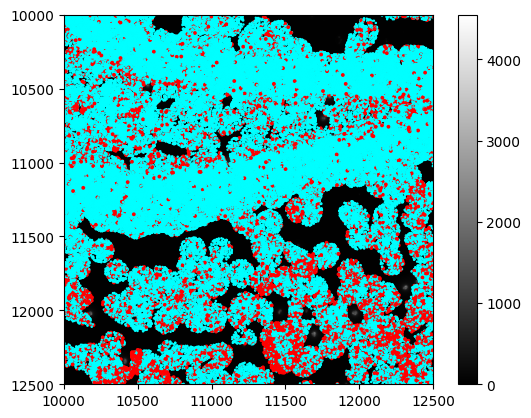

In [131]:
plot_spots(10000,12500,10000,12500,df_exp0,r"C:\Users\mdichgan\Documents\Helmholtz\send_to_Jakob\tif_images\background.tiff")

In [ ]:
def get_neg_spot_dens_array(spots: pd.DataFrame, x_min: int, x_max: int, y_min: int, y_max: int, image: str, bins):
    try: 
        if (x_min is None or x_max is None or y_min is None or y_max is None) and image is None:
            raise ValueError("please provide an image")        #or better: either provide a crop (x_min, x_max, y_min, y_max) or image? 
        
        if image is None:
            range = [[x_min,x_max],[y_min,y_max]]
        
        else:
            x = imread(image)
            range = [[0,x.shape[0]],[0,x.shape[1]]]
        
    except ValueError as e:
        print(e)

    #filter spots
    df = spots
    x_min, x_max, y_min, y_max = range[0][0], range[0][1], range[1][0], range[1][1]
    df = df.loc[(df['x']>= x_min) & (df['x']<=x_max) & (df['y']>=y_min) & (df['y']<=y_max)]

    true_spots = spots.loc[spots['in_correct_celltype'] == True]
    x_t = true_spots['x']
    y_t = true_spots['y']

    H_t, xedges, yedges = np.histogram2d(x_t, y_t, bins = bins, range = range)
    # Histogram does not follow Cartesian convention (see Notes),
    # therefore transpose H for visualization purposes.
    H_t = H_t.T

    false_spots = spots.loc[spots['in_correct_celltype'] == False]
    x_f = false_spots['x']
    y_f = false_spots['y']

    H_f, xedges, yedges = np.histogram2d(x_f, y_f, bins = bins, range = range)
    # Histogram does not follow Cartesian convention (see Notes),
    # therefore transpose H for visualization purposes.
    H_f = H_f.T
    H = H_f/(H_f + H_t)

    return H,range
    

In [ ]:
get_neg_spot_dens_array(df_exp0,10000,12500,10000,12500,image=None,bins = 20)

In [ ]:
def wrong_spot_density(spots: pd.DataFrame, x_min: int, x_max: int, y_min: int, y_max: int
                       ,image, #smooth: float
                       bins
                       ):
    # bins mehrere Optionen (int, zwei arrays etc.) -> wie?
    
#      binsint or array_like or [int, int] or [array, array], optional
# The bin specification:

# If int, the number of bins for the two dimensions (nx=ny=bins).

# If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).

# If [int, int], the number of bins in each dimension (nx, ny = bins).

# If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).

# A combination [int, array] or [array, int], where int is the number of bins and array is the bin edges.

   
    H, range = get_neg_spot_dens_array(spots,x_min,x_max,y_min,y_max,image,bins)
    x_min, x_max, y_min, y_max = range[0][0], range[0][1], range[1][0], range[1][1]

    fig = plt.figure()
    ax = fig.add_subplot(title='false spots density')
    plot = plt.imshow(H, interpolation='nearest', origin='upper',
            extent=[x_min, x_max, y_max, y_min])
    fig.colorbar(plot)


In [ ]:
wrong_spot_density(df_exp0,10000,12500,10000,12500,image=None,bins = 20)